# **Spark mini-project (Luca Nudo & Emidio Grillo)**

### Bonus Assignment 1: Automated Data Retrieval Script

This section implements a robust Python script designed to automate the downloading of gas price datasets directly from the GitHub repository.

**Key features of this implementation:**
* **Directory Management:** Automatically creates the target folder if it does not exist.
* **Error Handling:** Uses `raise_for_status()` and `try-except` blocks to handle network issues or missing files.
* **Real-time Monitoring:** Reports the size of each downloaded file in **MB** for easy verification of data integrity.

In [77]:
import os
import requests

def download_gas_data(target_directory):
    base_url = "https://raw.githubusercontent.com/rvm-courses/GasPrices/master/"

    files_to_download = [
        "Prix2022S1.csv.gz", "Prix2022S2.csv.gz",
        "Prix2023.csv.gz", "Prix2024.csv.gz",
        "Stations2024.csv.gz", "Services2024.csv.gz"
    ]

    # This creates the directory if it doesn't exist
    os.makedirs(target_directory, exist_ok=True)

    for file_name in files_to_download:
        url = f"{base_url}{file_name}"
        save_path = os.path.join(target_directory, file_name)

        print(f"Downloading: {file_name}...")
        try:
            # Added a 15-second timeout to prevent the script from hanging
            response = requests.get(url, timeout=15)
            response.raise_for_status()  # # Checking if there are any HTTP errors

            with open(save_path, "wb") as f:
                f.write(response.content)

            # VERIFICATION: Checking the file size on disk
            size_mb = os.path.getsize(save_path) / (1024 * 1024)
            print(f" Successfully saved! Size: {size_mb:.2f} MB")

        except requests.exceptions.RequestException as e:
            print(f" Error downloading {file_name}: {e}")

In [78]:
download_gas_data("gas_data_folder")

Downloading: Prix2022S1.csv.gz...
 Successfully saved! Size: 15.59 MB
Downloading: Prix2022S2.csv.gz...
 Successfully saved! Size: 13.88 MB
Downloading: Prix2023.csv.gz...
 Successfully saved! Size: 23.50 MB
Downloading: Prix2024.csv.gz...
 Successfully saved! Size: 22.41 MB
Downloading: Stations2024.csv.gz...
 Successfully saved! Size: 0.35 MB
Downloading: Services2024.csv.gz...
 Successfully saved! Size: 0.24 MB


### Bonus Assignment 2: Professional Parameter Management via YAML

This advanced version demonstrates the separation of **Logic** (Python code) from **Configuration** (Parameters). By using an external `config.yaml` file, the script becomes highly scalable and easier to maintain.

**Technical Highlights:**
* **YAML Integration:** Centralizes paths, URLs, and metadata in a human-readable configuration file.
* **Dynamic File Generation:** Instead of a hardcoded list, the script intelligently builds the file list based on the `start_year` and `end_year` defined in the configuration.
* **Scalability:** New datasets can be included simply by updating the YAML file, without the need to modify the core Python source code.

In [79]:
pip install pyyaml

In [80]:
%%writefile config.yaml
# ==========================================
# GAS PRICES PROJECT - GLOBAL CONFIGURATION
# ==========================================

# Local directory where the data will be stored
storage:
  folder_name: "gas_data_folder"

# Years of interest for the analysis
processing_range:
  start_year: 2022
  end_year: 2024

# Remote repository details
github_repository:
  base_url: "https://raw.githubusercontent.com/rvm-courses/GasPrices/master/"

# Here we only list files that DO NOT follow the year-based logic (e.g., metadata/registries)
  metadata_files:
    - "Stations2024.csv.gz"
    - "Services2024.csv.gz"


Overwriting config.yaml


In [81]:
import os
import requests
import yaml

def download_gas_data_from_yaml(config_file="config.yaml"):
    # 1. Loading the configuration from the YAML file
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)

    # 2. Dynamic file list generation
    folder = config['storage']['folder_name']
    base_url = config['github_repository']['base_url']

    start_year = config['processing_range']['start_year']
    end_year = config['processing_range']['end_year']

    # We build the list of files to download automatically
    files = []
    for year in range(start_year, end_year + 1):
        if year == 2022:
            # Special case for 2022 (split into two semesters)
            files.append(f"Prix{year}S1.csv.gz")
            files.append(f"Prix{year}S2.csv.gz")
        else:
            # Standard format for other years
            files.append(f"Prix{year}.csv.gz")

    # Adding the extra metadata files (Stations and Services) from the YAML
    files.extend(config['github_repository']['metadata_files'])
    # ----------------------------------------------------

    # 3. Creating the destination folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    print(f"--- Starting Download into folder: {folder} ---")

    for file_name in files:
        url = f"{base_url}{file_name}"
        save_path = os.path.join(folder, file_name)

        try:
            response = requests.get(url, timeout=15)
            response.raise_for_status()

            with open(save_path, "wb") as f:
                f.write(response.content)

            size_mb = os.path.getsize(save_path) / (1024 * 1024)
            print(f"{file_name} saved ({size_mb:.2f} MB)")

        except Exception as e:
            print(f"Error downloading {file_name}: {e}")

In [82]:
# Running the function
download_gas_data_from_yaml()

--- Starting Download into folder: gas_data_folder ---
Prix2022S1.csv.gz saved (15.59 MB)
Prix2022S2.csv.gz saved (13.88 MB)
Prix2023.csv.gz saved (23.50 MB)
Prix2024.csv.gz saved (22.41 MB)
Stations2024.csv.gz saved (0.35 MB)
Services2024.csv.gz saved (0.24 MB)


## Spark Setup
Installing PySpark and initializing the Spark Session.

In [83]:
# Installing PySpark
!pip install pyspark

from pyspark.sql import SparkSession
import os
import yaml

# Initializing the Spark Session
spark = SparkSession.builder \
    .appName("GasPricesAnalysis") \
    .getOrCreate()

print("Spark Session successfully initialized!")

Spark Session successfully initialized!


In [84]:
spark

## **Data Preparation**

## Step 1

### Merging Gas prices Datasets
This step centralizes the raw historical data into a single Spark DataFrame, ensuring a consistent structure for the subsequent analysis.

* **Configuration-Driven Loading**: The function reads from `config.yaml` to dynamically determine the processing range and storage location, making the pipeline easily adaptable.
* **Handling File Naming Exceptions**: It specifically manages the 2022 dataset, which is split into two semesters (`Prix2022S1` and `Prix2022S2`), while handling standard yearly files for 2023 and 2024.
* **Schema Standardization**: Since the raw CSV files lack headers, we manually define and map a clear schema (`id_station`, `postal_code`, `date`, `fuel_type`, `price`, etc.) to the data.
* **Spark Parallel Processing**: By passing a list of file paths to `spark.read.csv`, Spark optimizes the ingestion process, loading and merging millions of rows across multiple partitions in a single operation.

In [85]:
def merge_gas_price_files(config_file="config.yaml"):

    # 1. Loading configuration
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)

    folder = config['storage']['folder_name']
    start_year = config['processing_range']['start_year']
    end_year = config['processing_range']['end_year']

    # 2. Renaming the columns
    column_names = [
        "id_station", "postal_code", "pop_type",
        "latitude", "longitude", "date",
        "fuel_id", "fuel_type", "price"
    ]

    # 3. Building the list of paths for price files only (Prix)
    file_paths = []
    for year in range(start_year, end_year + 1):
        if year == 2022:
            file_paths.append(os.path.join(folder, f"Prix{year}S1.csv.gz"))
            file_paths.append(os.path.join(folder, f"Prix{year}S2.csv.gz"))
        else:
            file_paths.append(os.path.join(folder, f"Prix{year}.csv.gz"))

    print(f"Loading files: {[os.path.basename(p) for p in file_paths]}")

    # 4. Loading and Merging using Spark
    df_prices = spark.read.csv(file_paths, sep=';', header=False, inferSchema=True)

    # 5. Putting the right name for the columns
    df_prices = df_prices.toDF(*column_names)

    print(f"Successfully merged into a single DataFrame.")
    print(f"Total rows in merged dataset: {df_prices.count():,}")

    return df_prices

# Running the merging process
prices_df = merge_gas_price_files()

# Showing the first 5 rows to check the data
prices_df.show(5)

Loading files: ['Prix2022S1.csv.gz', 'Prix2022S2.csv.gz', 'Prix2023.csv.gz', 'Prix2024.csv.gz']
Successfully merged into a single DataFrame.
Total rows in merged dataset: 14,214,837
+----------+-----------+--------+---------+---------+-------------------+-------+---------+-----+
|id_station|postal_code|pop_type| latitude|longitude|               date|fuel_id|fuel_type|price|
+----------+-----------+--------+---------+---------+-------------------+-------+---------+-----+
|   1000001|       1000|       R|4620100.0| 519800.0|2023-01-02 07:53:26|      1|   Gazole|1.867|
|   1000001|       1000|       R|4620100.0| 519800.0|2023-01-05 09:33:37|      1|   Gazole|1.877|
|   1000001|       1000|       R|4620100.0| 519800.0|2023-01-09 14:51:49|      1|   Gazole|1.875|
|   1000001|       1000|       R|4620100.0| 519800.0|2023-01-11 09:23:54|      1|   Gazole|1.859|
|   1000001|       1000|       R|4620100.0| 519800.0|2023-01-13 09:07:40|      1|   Gazole|1.862|
+----------+-----------+--------+-

 ### Feature Engineering & Geolocation

We enhance our dataset by:
1. **Converting the date** from a string to a proper timestamp format.
2. **Extracting temporal features**: Year, Month, and Week of the year to facilitate time-series analysis.
3. **Scaling Geolocation**: Dividing latitude and longitude by $10^5$ to convert them into standard decimal degrees.

In [86]:
from pyspark.sql import functions as F

# We create 'processed_df' based on the clean 'prices_df'. This prevents "multi-run" errors where numbers are divided multiple times
processed_df = prices_df \
    .withColumn("date", F.to_timestamp("date")) \
    .withColumn("year", F.year("date")) \
    .withColumn("month", F.month("date")) \
    .withColumn("week", F.weekofyear("date")) \
    .withColumn("latitude", F.col("latitude") / 100000) \
    .withColumn("longitude", F.col("longitude") / 100000)

# Verification: Check that numbers are human-readable
print("Transformation complete. Checking Geolocation and Time features:")
processed_df.select("date", "year", "month", "week", "latitude", "longitude", "price").show(5)

Transformation complete. Checking Geolocation and Time features:
+-------------------+----+-----+----+--------+---------+-----+
|               date|year|month|week|latitude|longitude|price|
+-------------------+----+-----+----+--------+---------+-----+
|2023-01-02 07:53:26|2023|    1|   1|  46.201|    5.198|1.867|
|2023-01-05 09:33:37|2023|    1|   1|  46.201|    5.198|1.877|
|2023-01-09 14:51:49|2023|    1|   2|  46.201|    5.198|1.875|
|2023-01-11 09:23:54|2023|    1|   2|  46.201|    5.198|1.859|
|2023-01-13 09:07:40|2023|    1|   2|  46.201|    5.198|1.862|
+-------------------+----+-----+----+--------+---------+-----+
only showing top 5 rows


### Registering Spark SQL Table

We register the cleaned `processed_df` as a temporary SQL view named `gas_prices`. This allows us to perform data analysis using standard SQL syntax alongside the Spark DataFrame API.

In [87]:
# Registering the DataFrame as a SQL temporary view
processed_df.createOrReplaceTempView("gas_prices")

print("DataFrame successfully registered as table 'gas_prices'.")

DataFrame successfully registered as table 'gas_prices'.


### Investigating NULL values

Before proceeding with the removal of incomplete records during the data preparation phase, it is essential to investigate whether these entries contain **recoverable information**.

The objective of this analysis is to verify:
* Whether records with a null `fuel_type` possess a valid `fuel_id` or `price`.
* If it is possible to map missing `fuel_type` values using the `fuel_id` if that identifier is associated with a specific name elsewhere in the dataset.

This investigation supports the requirement to use basic statistics to evaluate the relevance of data points. It helps determine whether to proceed with a **safe removal** of the data or an **imputation** (data recovery) process to ensure integrity for the next steps of the project.

In [88]:
# 1. Checking fuel_id and price range for records where fuel_type is NULL
null_analysis = spark.sql("""
    SELECT
        fuel_id,
        fuel_type,
        COUNT(*) as count,
        MIN(price) as min_val,
        MAX(price) as max_val
    FROM gas_prices
    WHERE fuel_type IS NULL
    GROUP BY fuel_id, fuel_type
""")

print("Analysis of records with NULL fuel_type:")
null_analysis.show()

# 2. Verifying if these fuel_ids exist elsewhere with a valid name. This tells us if we can 'recover' the name by mapping the ID.
recovery_check = spark.sql("""
    SELECT fuel_id, fuel_type, COUNT(*) as frequency
    FROM gas_prices
    WHERE fuel_id IN (SELECT DISTINCT fuel_id FROM gas_prices WHERE fuel_type IS NULL)
    GROUP BY fuel_id, fuel_type
    ORDER BY fuel_id, frequency DESC
""")

print("Checking if missing fuel_types can be recovered via fuel_id:")
recovery_check.show()

Analysis of records with NULL fuel_type:
+-------+---------+-----+-------+-------+
|fuel_id|fuel_type|count|min_val|max_val|
+-------+---------+-----+-------+-------+
|   NULL|     NULL|12756|   NULL|   NULL|
+-------+---------+-----+-------+-------+

Checking if missing fuel_types can be recovered via fuel_id:
+-------+---------+---------+
|fuel_id|fuel_type|frequency|
+-------+---------+---------+
+-------+---------+---------+



### Filtering and Final Cleaning

Based on the previous investigation, the 12,756 NULL records are completely unusable as they lack IDs, names, and price data. Following the project requirements to filter out fuel types of little interest through basic statistics, we will now remove all NULL records.

In [89]:
# We create a new view 'prices_no_nulls' that contains only complete records. This prepares the data for the next phase of the project.
prices_no_nulls_df = spark.sql("""
    SELECT * FROM gas_prices
    WHERE fuel_type IS NOT NULL
""")

# Registering the new view to keep the pipeline organized
prices_no_nulls_df.createOrReplaceTempView("prices_no_nulls")

print(f"NULL removal complete.")
print(f"Records before: {spark.table('gas_prices').count():,}")
print(f"Records after:  {prices_no_nulls_df.count():,}")
print(f"Rows removed:   {spark.table('gas_prices').count() - prices_no_nulls_df.count():,}")

NULL removal complete.
Records before: 14,214,837
Records after:  14,202,081
Rows removed:   12,756


### Analyzing Fuel Type Distribution

We must evaluate which gas types are relevant for the remainder of the analysis using basic statistics. The requirements state that two fuel types of little interest can be filtered out to streamline the dataset.

In this step, we will aggregate the records by `fuel_type` to observe their frequency and identify the candidates for removal.

In [90]:
# We use Spark SQL to count occurrences for each fuel type to determine which ones are the least relevant for the project.
fuel_distribution = spark.sql("""
    SELECT fuel_type, COUNT(*) as record_count
    FROM prices_no_nulls
    GROUP BY fuel_type
    ORDER BY record_count ASC
""")

print("Fuel type distribution (from least to most frequent):")
fuel_distribution.show()

Fuel type distribution (from least to most frequent):
+---------+------------+
|fuel_type|record_count|
+---------+------------+
|     GPLc|      619759|
|     SP95|      961020|
|      E85|     1390580|
|     SP98|     3425844|
|      E10|     3559498|
|   Gazole|     4245380|
+---------+------------+



### Strategic Filtering of Fuel Types

Based on the statistical distribution obtained, we have identified the two fuel types with the lowest frequency in our dataset: **GPLc** and **SP95**.

Following the project requirements to filter out gas types of little interest, we will proceed to remove these two categories. This focuses our analysis on the most relevant fuels in the French market (Gazole, E10, SP98, and E85), ensuring more robust results for the Price Index calculation and the predictive modeling phase.

In [91]:
# We remove GPLc and SP95 as they are the least relevant based on our statistical analysis.
final_prices_df = spark.sql("""
    SELECT * FROM prices_no_nulls
    WHERE fuel_type NOT IN ('GPLc', 'SP95')
""")

# Register the cleaned dataset as a temporary view for the next steps
final_prices_df.createOrReplaceTempView("final_prices")

print(f"Strategic filtering complete.")
print(f"Final record count for price analysis: {final_prices_df.count():,}")

# Quick verification of the remaining fuel types
spark.sql("SELECT fuel_type, COUNT(*) as count FROM final_prices GROUP BY fuel_type ORDER BY count DESC").show()

Strategic filtering complete.
Final record count for price analysis: 12,621,302
+---------+-------+
|fuel_type|  count|
+---------+-------+
|   Gazole|4245380|
|      E10|3559498|
|     SP98|3425844|
|      E85|1390580|
+---------+-------+



### Stations Dataset Structure and Null Analysis

In this step, we analyze the **Stations2024** registry. We need to:
1. **Verify the structure**: Ensure columns are correctly mapped (ID, postal code, type, coordinates, address, and city).
2. **Perform a Missing Value Analysis**: Identify NULL values across all columns to determine if any stations lack critical geographic or identification data.


In [92]:
import os
from pyspark.sql import functions as F

with open("config.yaml", 'r') as f:
    config = yaml.safe_load(f)

# 1. Defining the path and column names
# The stations file is a core requirement for geographic analysis
stations_path = os.path.join(config['storage']['folder_name'], "Stations2024.csv.gz")
stations_columns = ["id_station", "postal_code", "pop_type", "latitude", "longitude", "address", "city"]

# 2. Loading the dataset with the correct separator
# We use the pipe (|) delimiter to ensure the 7 columns are correctly parsed
# header=False is used because the source files do not contain headers
raw_stations_df = spark.read.csv(stations_path, sep='|', header=False, inferSchema=True)

# 3. Assigning column names and validating structure
# We ensure the number of columns found matches our predefined list to avoid Arity Mismatch
if len(raw_stations_df.columns) == len(stations_columns):
    stations_df = raw_stations_df.toDF(*stations_columns)
    print(f"Stations dataset correctly loaded with {len(stations_df.columns)} columns.")
else:
    # Manual mapping as a safety measure if arity varies
    stations_df = raw_stations_df
    for i, name in enumerate(stations_columns):
        if i < len(stations_df.columns):
            stations_df = stations_df.withColumnRenamed(stations_df.columns[i], name)
    print(f"Warning: Structural mismatch. Assigned names to {len(stations_df.columns)} columns.")

# 4. Missing Value Analysis
# We count NULLs for each column to assess data completeness
print("\nMissing values analysis for Stations dataset:")
stations_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in stations_df.columns]).show()

# 5. Registering the SQL View
# Making the data available for Spark SQL as required by project specifications
stations_df.createOrReplaceTempView("stations_registry")

Stations dataset correctly loaded with 7 columns.

Missing values analysis for Stations dataset:
+----------+-----------+--------+--------+---------+-------+----+
|id_station|postal_code|pop_type|latitude|longitude|address|city|
+----------+-----------+--------+--------+---------+-------+----+
|         0|          0|       0|      69|       68|      1|   0|
+----------+-----------+--------+--------+---------+-------+----+



Based on the missing value analysis, we identified 69 records in the Stations dataset that lack geographic coordinates (**latitude** and **longitude**).

The rationale for removing these specific records is as follows:
1. **Mapping Requirement**: A core objective of this project is the spatial visualization of data. A station without coordinates cannot be placed on a map, making it a "dead" record for visualization purposes.
2. **Data Integrity**: Missing coordinates are a structural failure for a geographic registry.
3. **Negligible Impact**: Removing 69 records out of several thousands represents a loss of less than 0.5% of the registry, which has no significant impact on the statistical validity of the national price analysis.

By dropping these rows, we ensure that the final "Master" dataset is robust and ready for error-free mapping and spatial joins.

In [93]:
# We remove stations with missing geographic coordinates (latitude/longitude) to ensure the integrity of future mapping and spatial analysis.

cleaned_stations_df = stations_df.dropna(subset=["latitude", "longitude"])

# Update the SQL view with cleaned data
cleaned_stations_df.createOrReplaceTempView("stations_registry")

print(f"Cleaning complete.")
print(f"Stations removed: {stations_df.count() - cleaned_stations_df.count()}")
print(f"Remaining stations: {cleaned_stations_df.count()}")

Cleaning complete.
Stations removed: 69
Remaining stations: 14093


## Services Dataset structure and Null Analysis

In this step, we analyze the **Services2024** registry. The initial structural check revealed that the dataset contains six columns, including geographic metadata repeated from the stations registry. We will map these columns correctly to isolate the **id_station** and the **services** string, followed by a missing value analysis to ensure data integrity for the upcoming join operations.


In [94]:
# 1. Defining the path and column names for services
# Based on the structural analysis, this file contains 6 columns
services_path = os.path.join(config['storage']['folder_name'], "Services2024.csv.gz")
services_columns = ["id_station", "postal_code", "pop_type", "latitude", "longitude", "services"]

# 2. Loading the dataset with the pipe separator
# We use the pipe (|) delimiter to correctly split the 6 attributes
raw_services_df = spark.read.csv(services_path, sep='|', header=False, inferSchema=True)

# 3. Assigning column names safely
# We check if the columns match the identified 6-column structure
if len(raw_services_df.columns) == len(services_columns):
    services_df = raw_services_df.toDF(*services_columns)
    print(f"Services dataset correctly loaded with {len(services_df.columns)} columns.")
else:
    # Fallback: rename only the essential columns if the count is still different
    services_df = raw_services_df.withColumnRenamed(raw_services_df.columns[0], "id_station") \
                                 .withColumnRenamed(raw_services_df.columns[-1], "services")
    print(f"Warning: Structural mismatch. Found {len(raw_services_df.columns)} columns instead of 6.")

# 4. Missing Value Analysis
# We focus on the id_station and the services list
print("\nMissing values analysis for Services dataset:")
services_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in services_df.columns]).show()

# 5. Registering the SQL View
# We keep only the necessary columns for the future join to avoid redundancy
final_services_df = services_df.select("id_station", "services")
final_services_df.createOrReplaceTempView("services_registry")

Services dataset correctly loaded with 6 columns.

Missing values analysis for Services dataset:
+----------+-----------+--------+--------+---------+--------+
|id_station|postal_code|pop_type|latitude|longitude|services|
+----------+-----------+--------+--------+---------+--------+
|         0|          0|       0|      69|       68|    1066|
+----------+-----------+--------+--------+---------+--------+



We identified 1,066 records with a NULL value in the `services` column. Unlike the missing coordinates in the Stations registry, we have decided **not to remove** these records based on the following logic:

1. **Representation of Reality**: A NULL value in this context does not indicate "missing" or "broken" data; rather, it describes a reality where a gas station operates normally but offers **no extra services** (such as a car wash, a restaurant, or Wi-Fi).
2. **Preventing Data Loss**: Each of these 1,066 stations is associated with valid price records in our primary dataset. If we were to delete these stations from the registry, we would lose all the corresponding price data, leading to a significant loss of information.
3. **Avoiding Market Distortion**: Removing these stations would bias our analysis toward larger, service-oriented stations, ignoring smaller or more basic stations that still contribute to the national price average.


# Step 2

### Computing the Week Index

In this step, we create a linear timeline for our 3-year analysis (2022-2024). Instead of using repeating week numbers (1-52) for each year, we compute a **Week Index** that ranges from 1 to 156.

**Formula**: $((Current~Year - Start~Year) \times 52) + Week~Number$

This transformation is essential for time-series visualization, allowing us to treat the entire period as a continuous sequence.

In [95]:
# 1. Retrieving the baseline year using Spark SQL
# We query the 'final_prices' view registered in the previous step
start_year = spark.sql("SELECT MIN(year) FROM final_prices").collect()[0][0]
print(f"Baseline year for indexing: {start_year}")

# 2. Computing the Week Index using a SQL Query
# We apply the formula: ((year - start_year) * 52) + week
# This ensures 2022/W1 = 1 and 2024/W52 = 156
query = f"""
    SELECT *,
           ((year - {start_year}) * 52 + week) AS week_index
    FROM final_prices
"""

# Executing the query and store the result in a new DataFrame
prices_with_week = spark.sql(query)

# 3. Range Verification
# We verify that the week_index correctly spans from 1 to 156
range_val = prices_with_week.selectExpr("MIN(week_index)", "MAX(week_index)").collect()[0]
print(f"Week Index successfully computed from {range_val[0]} to {range_val[1]}")

# Displaying sample results
prices_with_week.select("id_station", "year", "week", "week_index").show(10)

# Registering the result as a new view for the next sub-step (Price Index)
prices_with_week.createOrReplaceTempView("prices_with_week_view")

Baseline year for indexing: 2022
Week Index successfully computed from 1 to 156
+----------+----+----+----------+
|id_station|year|week|week_index|
+----------+----+----+----------+
|   1000001|2023|   1|        53|
|   1000001|2023|   1|        53|
|   1000001|2023|   2|        54|
|   1000001|2023|   2|        54|
|   1000001|2023|   2|        54|
|   1000001|2023|   3|        55|
|   1000001|2023|   3|        55|
|   1000001|2023|   3|        55|
|   1000001|2023|   4|        56|
|   1000001|2023|  19|        71|
+----------+----+----+----------+
only showing top 10 rows


### Sanity Check: `week_index` Integrity

Before using `week_index` as the backbone for time-based aggregation and trend analysis, we run a lightweight integrity check to ensure the feature is well-formed.

This validation focuses on:
* **Completeness**: no missing values (NULLs).
* **Basic validity**: no negative indices.
* **Range plausibility**: the index spans a meaningful interval (min < max), consistent with a multi-week / multi-year dataset.

These checks act as a simple guardrail to catch silent issues early (e.g., date parsing problems or incorrect transformations) and improve reproducibility.


In [96]:
from pyspark.sql import functions as F

# 1. week_index basic integrity
wk_stats = final_indexed_df.agg(
    F.min("week_index").alias("min_week_index"),
    F.max("week_index").alias("max_week_index"),
    F.sum(F.col("week_index").isNull().cast("int")).alias("null_week_index")
).collect()[0]

print("week_index stats:", dict(wk_stats.asDict()))

assert wk_stats["null_week_index"] == 0, "week_index contains NULL values"
assert wk_stats["min_week_index"] >= 0, "week_index has negative values (unexpected)"
assert wk_stats["max_week_index"] > wk_stats["min_week_index"], "week_index range looks wrong"


week_index stats: {'min_week_index': 1, 'max_week_index': 156, 'null_week_index': 0}


The `week_index` passed the sanity check (no NULLs, valid range: 1–156).


### Computing the Price Index

In this step, we calculate the **Price Index** for each gas type sold at each station. This index compares a station’s price to the national average for the same **week** and **fuel type**. By normalizing the data, we can identify which stations are more expensive or cheaper than the market average, regardless of general price trends or inflation.

We use **Spark Window Functions** to calculate the national weekly average. This approach is highly efficient, as it allows us to compute aggregates and append them to each row without the need for complex joins.

**Formula:**

$$
\text{Price Index} = 100 \times \left( \frac{\text{Station Price} - \text{National Weekly Avg}}{\text{National Weekly Avg}} + 1 \right)
$$


In [97]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# We use a Window Function to calculate the national average for each fuel type per week. The data is partitioned by 'week_index' and 'fuel_type'.

price_index_query = """
    SELECT *,
           -- Calculate the national average for the specific week and fuel type
           AVG(price) OVER(PARTITION BY week_index, fuel_type) as national_weekly_avg
    FROM prices_with_week_view
"""

# Execute the query to add the reference average
enriched_prices_df = spark.sql(price_index_query)

# Applying the Price Index formula and rounding for better readability
# The formula ensures that the national average corresponds to a value of 100.
final_indexed_df = enriched_prices_df.withColumn(
    "price_index",
    F.round(100 * ((F.col("price") - F.col("national_weekly_avg")) / F.col("national_weekly_avg") + 1), 2)
).withColumn(
    "national_weekly_avg",
    F.round(F.col("national_weekly_avg"), 3)
)

# Register the final table as a temporary view
final_indexed_df.createOrReplaceTempView("final_indexed_prices")

print("Price Index successfully computed.")
# Verification of the first 10 records
final_indexed_df.select("id_station", "fuel_type", "week_index", "price", "national_weekly_avg", "price_index").show(10)

Price Index successfully computed.
+----------+---------+----------+-----+-------------------+-----------+
|id_station|fuel_type|week_index|price|national_weekly_avg|price_index|
+----------+---------+----------+-----+-------------------+-----------+
|   1000001|     SP98|         2|1.711|              1.788|      95.72|
|   1000007|     SP98|         2|1.689|              1.788|      94.49|
|   1000007|     SP98|         2|1.708|              1.788|      95.55|
|   1000012|     SP98|         2|1.845|              1.788|     103.21|
|   1000012|     SP98|         2|1.845|              1.788|     103.21|
|   1000012|     SP98|         2|1.845|              1.788|     103.21|
|   1000012|     SP98|         2|1.852|              1.788|      103.6|
|   1000012|     SP98|         2|1.852|              1.788|      103.6|
|   1000012|     SP98|         2|1.859|              1.788|      104.0|
|   1000012|     SP98|         2|1.859|              1.788|      104.0|
+----------+---------+-------

### Sanity Check: `price_index` Distribution & Outliers

The `price_index` is a derived metric used across the project (maps, comparisons, and forecasting). Since it depends on window aggregations (national baseline) and arithmetic transformations, we verify that it behaves as expected.

This validation includes:
* **Completeness**: no missing values (NULLs).
* **Distribution sanity**: key quantiles (P01, P50, P99) to confirm the index is centered around plausible values.
* **Extreme outliers**: an indicative share of very large deviations to detect potential data-quality or computation issues.

The goal is not to “clean” the data here, but to confirm that the computed metric is consistent and reliable for downstream analysis.



In [98]:
# 2. price_index distribution sanity check
pi_nulls = final_indexed_df.select(
    F.sum(F.col("price_index").isNull().cast("int")).alias("null_price_index")
).collect()[0]["null_price_index"]

assert pi_nulls == 0, "price_index contains NULL values"

# Approx quantiles (fast on big data)
q = final_indexed_df.approxQuantile("price_index", [0.01, 0.50, 0.99], 0.001)
print(f"price_index quantiles: P01={q[0]:.2f}, P50={q[1]:.2f}, P99={q[2]:.2f}")

# Flag extreme outliers (very permissive thresholds)
outlier_share = final_indexed_df.filter((F.col("price_index") < 50) | (F.col("price_index") > 150)) \
    .count() / final_indexed_df.count()

print(f"price_index extreme outlier share (<50 or >150): {outlier_share:.6f}")

assert q[1] > 80 and q[1] < 120, "Median price_index is out of expected range (check computation)"


price_index quantiles: P01=90.37, P50=98.92, P99=116.44
price_index extreme outlier share (<50 or >150): 0.000250


The `price_index` passed the sanity check: values are well-centered around 100 (P50 ≈ 98.9) with a very low share of extreme outliers (~0.025%).


### Weekly Average Price Evolution

In this step, we visualize the temporal trend of gas prices in France from **2022 to 2024**. We aggregate the millions of records into a **weekly national average** for each fuel type. This approach allows us to observe market fluctuations, price peaks, and the overall impact of the energy crisis across the three-year span.


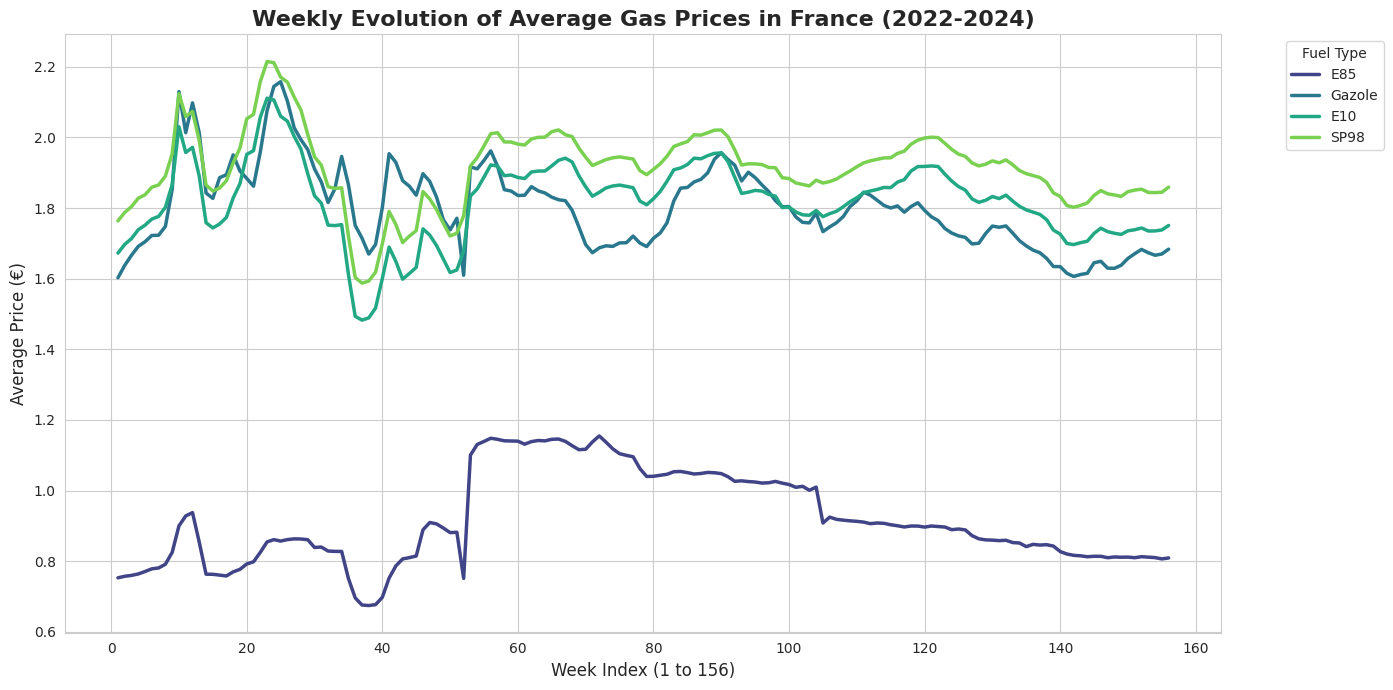

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aggregating data for visualization
# We calculate the average price for each fuel type per week index.
# We order by week_index to ensure the timeline is chronological.
viz_query = """
    SELECT
        week_index,
        fuel_type,
        AVG(price) as avg_weekly_price
    FROM final_indexed_prices
    GROUP BY week_index, fuel_type
    ORDER BY week_index
"""

# Converting the Spark result to a Pandas DataFrame for plotting
weekly_trends_pd = spark.sql(viz_query).toPandas()

# 2. Plotting the results using Seaborn
# We use a line plot where each fuel type is represented by a distinct color.
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")

line_plot = sns.lineplot(
    data=weekly_trends_pd,
    x="week_index",
    y="avg_weekly_price",
    hue="fuel_type",
    palette="viridis",
    linewidth=2.5
)

# 3. Customizing the chart
plt.title("Weekly Evolution of Average Gas Prices in France (2022-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Week Index (1 to 156)", fontsize=12)
plt.ylabel("Average Price (€)", fontsize=12)
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

## Bonus question

### Preparing Data for Geographic Mapping

In this sub-step, we prepare the dataset for geographic visualization. We join our indexed prices with the station registry to retrieve **postal codes**, extract the corresponding **department codes**, and compute the **average Price Index** for each department and fuel type.

This aggregation is necessary to color the map according to the relative price levels across regions.


In [100]:
from pyspark.sql import functions as F

# 1. Joining Prices with Station Metadata
# We need the 'postal_code' from the stations_registry to identify departments.
# We perform a LEFT JOIN to ensure we keep all indexed price records.
prices_with_geo = spark.sql("""
    SELECT
        p.fuel_type,
        p.price_index,
        s.postal_code
    FROM final_indexed_prices p
    LEFT JOIN stations_registry s ON p.id_station = s.id_station
""")

# 2. Extracting the Department Code (with Corsica included)
# We use 'when/otherwise' to map Corsica postal codes to 2A and 2B
# standard codes used by the GeoJSON

prices_with_dept = prices_with_geo.withColumn("full_pc", F.lpad(F.col("postal_code"), 5, "0")) \
    .withColumn("dept_code",
        F.when(F.col("full_pc").startswith("200") | F.col("full_pc").startswith("201"), "2A") # Corse-du-Sud
         .when(F.col("full_pc").startswith("202") | F.col("full_pc").startswith("206"), "2B") # Haute-Corse
         .otherwise(F.substring(F.col("full_pc"), 1, 2))
    )

# 3. Aggregating Price Index by Department
# We calculate the mean price_index per department and per fuel type.
# This value will determine the color intensity on our heat map.
dept_stats_df = prices_with_dept.groupBy("dept_code", "fuel_type").agg(
    F.avg("price_index").alias("avg_dept_price_index")
)

# Converting to Pandas for the Folium library
dept_stats_pd = dept_stats_df.toPandas()

print("Department-level aggregation complete.")
print(f"Sample of data for mapping (Department vs Price Index):")
print(dept_stats_pd.head(10))

Department-level aggregation complete.
Sample of data for mapping (Department vs Price Index):
  dept_code fuel_type  avg_dept_price_index
0        26       E85            100.933718
1        74       E85            102.664100
2        38    Gazole             99.945721
3        33    Gazole             98.887896
4        42       E85            101.694340
5        10       E10            100.154131
6        70       E10             99.494933
7        12       E10             99.562673
8        82       E85             98.043362
9        39    Gazole            100.095824


### Data Visualization: Geographic Price Index Analysis

In this stage of the analysis, we are exploring the spatial distribution of fuel prices across France. By aggregating the `price_index` at the departmental level, we can visualize regional disparities that might be hidden in national averages.

* **Departmental Mapping**: We use the first two digits of the station's postal code to map individual price records to their respective French departments.
* **Interactive Dashboarding**: The visualization is built using **Folium**, incorporating a **LayerControl** interface that allows for seamless switching between fuel types (Gazole, E10, SP98, and E85) within a single map frame.
* **Normalization & Color Scaling**: The map uses a sequential color scale (YlOrRd) to represent the average $Price~Index$. This highlights areas where local prices deviate from the national average of 100.
* **User Interactivity**: Each geographic layer is enhanced with **Tooltips**, providing on-hover information such as the department name and code, facilitating immediate data exploration.

### Reproducibility Note: Self-Contained GeoJSON Loading for the Choropleth Map

The choropleth visualization requires an external **France departments GeoJSON** file. To make the notebook **fully reproducible** in different environments (e.g., a clean grading runtime, a different filesystem layout, or a fresh Colab session), we add a small setup cell that:

* **Checks whether the GeoJSON file is available locally** at the expected path.
* **Downloads it automatically only if missing**, then loads it into the `france_geojson` variable used by Folium.

This avoids execution failures due to missing local files and ensures that the geographic visualization can be regenerated end-to-end without manual intervention.


In [101]:
import os
import json
import urllib.request

geojson_path = "/content/gas_data_folder/fr_departements.geojson"
geojson_url  = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"

# 1. Ensuring the folder exists
os.makedirs(os.path.dirname(geojson_path), exist_ok=True)

# 2. Downloading only if missing (self-contained execution)
if not os.path.exists(geojson_path):
    print("⬇️ GeoJSON not found locally. Downloading...")
    urllib.request.urlretrieve(geojson_url, geojson_path)
    print("Downloaded:", geojson_path)
else:
    print("GeoJSON found locally:", geojson_path)

# 3. Loading into the variable used by Folium
with open(geojson_path, "r", encoding="utf-8") as f:
    france_geojson = json.load(f)

print("france_geojson loaded:", len(france_geojson["features"]), "features")


GeoJSON found locally: /content/gas_data_folder/fr_departements.geojson
france_geojson loaded: 96 features


In [102]:
import folium

# 1. Initializing the Map
# We initialize the map without default tiles to manage backgrounds individually within layers
m = folium.Map(location=[46.5, 2.3], zoom_start=6, tiles=None)

# 2. Defining Fuel Types for the Analysis
fuels = ['Gazole', 'E10', 'SP98', 'E85']

# 3. Creating Integrated Layers for each Fuel Type
for fuel in fuels:
    # Filter the aggregated data for the specific fuel type
    fuel_data = dept_stats_pd[dept_stats_pd['fuel_type'] == fuel]

    # Create a FeatureGroup with 'overlay=False' to enable radio-button selection in the menu
    fg = folium.FeatureGroup(name=fuel, show=(fuel == 'Gazole'), overlay=False)

    # Add persistent background tiles to each individual group
    folium.TileLayer('CartoDB positron').add_to(fg)

    # Define the Choropleth logic for geographic price distribution
    choro = folium.Choropleth(
        geo_data=france_geojson,
        data=fuel_data,
        columns=["dept_code", "avg_dept_price_index"],
        key_on="feature.properties.code",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        highlight=True,
    )

    # Add the geographic geometry to the group
    choro.geojson.add_to(fg)

    # Add interactive Tooltips for department-specific details
    folium.GeoJson(
        france_geojson,
        style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
        tooltip=folium.GeoJsonTooltip(
            fields=['nom', 'code'],
            aliases=['Department:', 'Code:'],
            localize=True
        )
    ).add_to(fg)

    # Add the complete group (Tiles + Data + Tooltips) to the main map object
    fg.add_to(m)

# 4. Adding Integrated Layer Controls
# We add a menu in the top-right corner to allow switching between fuel types
folium.LayerControl(collapsed=False, position='topright').add_to(m)

# 5. Display the Interactive Map
m

## Exploratory Analysis: EV Development Proxy (Charging Availability)

To evaluate whether the development of electric mobility may relate to fuel price patterns, we introduce an **exploratory proxy** based on the station registry:

* **Proxy Definition**: a station is flagged as `has_ev = 1` if its listed services suggest **EV charging availability** (keyword-based match in the `services` field from *Services2024*).
* **Scope**: since the services registry is available for **2024**, the comparison is performed on **2024 fuel price observations**.
* **Interpretation**: this is an **association analysis** (correlation, not causation). EV charging presence is not a direct measure of EV adoption or demand, but it is a practical and reproducible proxy within the provided datasets.


In [103]:
from pyspark.sql import functions as F

# 1. Building an "EV charging" proxy from Services2024

# Clean services as a lowercase string (null-safe)
services_clean = services_df.withColumn(
    "services_str",
    F.lower(F.coalesce(F.col("services").cast("string"), F.lit("")))
)

# Keywords for a lightweight, robust match (French/English variants)
ev_keywords = [
    "borne", "bornes", "recharge", "recharg",
    "charging", "charge", "electri",
    "vehicule elect", "véhicule élect"
]
ev_regex = "(" + "|".join(ev_keywords) + ")"

# Flag stations that likely offer EV charging
ev_flag_df = services_clean.select(
    "id_station",
    F.when(F.col("services_str").rlike(ev_regex), F.lit(1)).otherwise(F.lit(0)).alias("has_ev")
).dropDuplicates(["id_station"])

# 2. Restricting prices to 2024 (to match Services2024 scope)
prices_2024_df = final_indexed_df.filter(F.col("year") == 2024)

# 3. Joining EV proxy with prices (default has_ev = 0 if missing)
prices_with_ev_2024 = prices_2024_df.join(ev_flag_df, on="id_station", how="left") \
    .withColumn("has_ev", F.coalesce(F.col("has_ev"), F.lit(0))) \
    .cache()

print("Joined dataset ready:", prices_with_ev_2024.count(), "rows")
prices_with_ev_2024.select("id_station", "year", "price_index", "has_ev").show(5, truncate=False)


Joined dataset ready: 4096957 rows
+----------+----+-----------+------+
|id_station|year|price_index|has_ev|
+----------+----+-----------+------+
|1000001   |2024|100.25     |0     |
|1000001   |2024|97.64      |0     |
|1000001   |2024|100.63     |0     |
|1000001   |2024|101.28     |0     |
|1000007   |2024|97.1       |0     |
+----------+----+-----------+------+
only showing top 5 rows


### EV Proxy Comparison: From Station Services to Price Index (2024)

After constructing the binary proxy `has_ev` from the *Services2024* registry and joining it to the 2024 fuel price dataset, we perform a first **high-level comparison** to assess whether stations that likely provide EV charging exhibit different fuel price patterns.

* **Grouping Strategy**: we split observations into two groups (`has_ev = 0` vs `has_ev = 1`) and compute the **average Price Index** for each group.
* **Why Price Index**: using the normalized `price_index` makes the comparison more robust across fuel types and price scales.
* **Output**: we report (i) the average index for each group, (ii) the number of observations and stations supporting each estimate, and (iii) a simple bar chart to visualize the magnitude of the difference.

This is an **exploratory association check** (not a causal claim). Any observed gap may also reflect structural differences between station types (e.g., geography, urban density, highway locations, or station size).


+------+------------------+-------+----------+
|has_ev|avg_price_index   |n_obs  |n_stations|
+------+------------------+-------+----------+
|0     |99.94304237178768 |3734938|8776      |
|1     |100.58769382269999|362019 |779       |
+------+------------------+-------+----------+



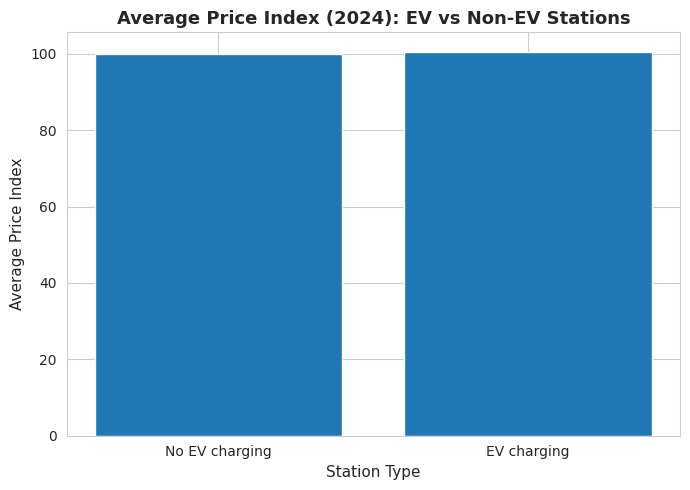

Avg Price Index (No EV): 99.94
Avg Price Index (EV):    100.59
Difference (EV - No EV): +0.64 index points


In [104]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1. Aggregating phase: average price_index by EV availability
ev_summary_df = prices_with_ev_2024.groupBy("has_ev").agg(
    F.avg("price_index").alias("avg_price_index"),
    F.count("*").alias("n_obs"),
    F.countDistinct("id_station").alias("n_stations")
).orderBy("has_ev")

ev_summary_df.show(truncate=False)

# 2. Converting to pandas for plotting
ev_summary_pd = ev_summary_df.toPandas()

# 3. Simple bar plot
plt.figure(figsize=(7, 5))

labels = ["No EV charging", "EV charging"]
x = ev_summary_pd["has_ev"].tolist()
y = ev_summary_pd["avg_price_index"].tolist()

plt.bar([labels[i] for i in x], y)

plt.title("Average Price Index (2024): EV vs Non-EV Stations", fontsize=13, fontweight="bold")
plt.ylabel("Average Price Index", fontsize=11)
plt.xlabel("Station Type", fontsize=11)
plt.tight_layout()
plt.show()

# 4. Printing a compact comparison (useful for the write-up)
avg_no_ev = float(ev_summary_pd.loc[ev_summary_pd["has_ev"] == 0, "avg_price_index"].iloc[0])
avg_ev    = float(ev_summary_pd.loc[ev_summary_pd["has_ev"] == 1, "avg_price_index"].iloc[0]) if (ev_summary_pd["has_ev"] == 1).any() else None

if avg_ev is not None:
    diff = avg_ev - avg_no_ev
    print(f"Avg Price Index (No EV): {avg_no_ev:.2f}")
    print(f"Avg Price Index (EV):    {avg_ev:.2f}")
    print(f"Difference (EV - No EV): {diff:+.2f} index points")
else:
    print("No stations flagged with has_ev=1. Consider broadening the keyword list.")


### Results Interpretation (2024): EV vs Non-EV Stations

The comparison shows a **small but measurable** difference in average fuel pricing (in normalized terms):

* **Average Price Index**:
  * **Non-EV stations**: ~**99.94**
  * **EV stations**: ~**100.59**
  * **Gap (EV − Non-EV)**: **+0.64 index points** (≈ +0.64%)

This suggests that stations offering (or likely offering) EV charging tend to have **slightly higher** fuel prices on average. However, the magnitude is limited, and the result should be interpreted with caution:

* **Not causal**: the proxy captures charging availability, not EV adoption or demand.
* **Possible confounders**: EV-equipped stations may be more common in **urban areas, premium locations, or highway networks**, which can influence pricing independently.
* **Next step (validation)**: to understand whether this gap is driven by geography, we extend the analysis at the **department level**, comparing the local share of EV stations with the average price index.


+---------+------------------+-----+----------+-------------+-------------------+
|dept_code|avg_price_index   |n_obs|n_stations|n_ev_stations|ev_station_share   |
+---------+------------------+-----+----------+-------------+-------------------+
|28       |99.78420944722552 |37556|78        |13           |0.16666666666666666|
|27       |99.43971650270198 |36085|96        |14           |0.14583333333333334|
|46       |100.76218727299141|13766|58        |8            |0.13793103448275862|
|41       |101.87166375912648|30954|82        |11           |0.13414634146341464|
|68       |99.5946073616762  |64143|115       |15           |0.13043478260869565|
|86       |100.18093362251588|19826|70        |9            |0.12857142857142856|
|10       |99.57719698910951 |31220|70        |9            |0.12857142857142856|
|87       |99.74658237652635 |21948|81        |10           |0.12345679012345678|
|73       |103.12306684972015|37876|100       |12           |0.12               |
|49       |98.62

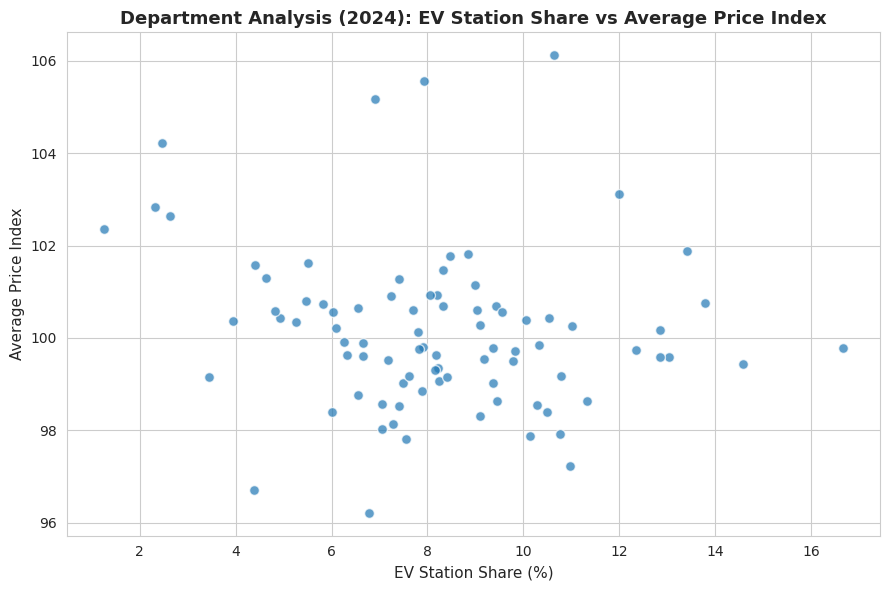

Pearson corr(ev_station_share, avg_price_index) = -0.1648


In [105]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1. Building department code from postal code (lightweight + reproducible)
# - DOM-TOM: 97x uses 3 digits (971, 972, ...)
# - Mainland: first 2 digits
df = prices_with_ev_2024.withColumn("postal_code_str", F.col("postal_code").cast("string"))

df = df.withColumn(
    "dept_code",
    F.when(F.col("postal_code_str").startswith("97"), F.substring("postal_code_str", 1, 3))
     .otherwise(F.substring("postal_code_str", 1, 2))
)

# Corsica split 2A/2B from 20xxx postal codes
df = df.withColumn(
    "pc5_int",
    F.substring("postal_code_str", 1, 5).cast("int")
).withColumn(
    "dept_code",
    F.when((F.col("dept_code") == "20") & (F.col("pc5_int").between(20000, 20199)), F.lit("2A"))
     .when((F.col("dept_code") == "20") & (F.col("pc5_int").between(20200, 20620)), F.lit("2B"))
     .otherwise(F.col("dept_code"))
).drop("pc5_int")

# 2. Department-level summary
dept_summary_df = df.groupBy("dept_code").agg(
    F.avg("price_index").alias("avg_price_index"),
    F.count("*").alias("n_obs"),
    F.countDistinct("id_station").alias("n_stations"),
    F.countDistinct(F.when(F.col("has_ev") == 1, F.col("id_station"))).alias("n_ev_stations")
).withColumn(
    "ev_station_share", F.col("n_ev_stations") / F.col("n_stations")
)

# Filtering small departments to reduce noise
dept_summary_df = dept_summary_df.filter(F.col("n_stations") >= 30)

dept_summary_df.orderBy(F.desc("ev_station_share")).show(10, truncate=False)

# 3. Converting to pandas for plotting
dept_pd = dept_summary_df.select(
    "dept_code", "avg_price_index", "ev_station_share", "n_stations"
).toPandas()

# 4. Scatter plot: %EV stations vs avg price index
plt.figure(figsize=(9, 6))

x = (dept_pd["ev_station_share"] * 100).values
y = dept_pd["avg_price_index"].values

plt.scatter(x, y, alpha=0.7, edgecolor="w", s=50)

plt.title("Department Analysis (2024): EV Station Share vs Average Price Index", fontsize=13, fontweight="bold")
plt.xlabel("EV Station Share (%)", fontsize=11)
plt.ylabel("Average Price Index", fontsize=11)
plt.tight_layout()
plt.show()

# 5. Simple correlation (Pearson)
corr = dept_pd["ev_station_share"].corr(dept_pd["avg_price_index"])
print(f"Pearson corr(ev_station_share, avg_price_index) = {corr:.4f}")


### Department-Level Results (2024): EV Station Share vs Average Price Index

To control for geographical heterogeneity, we aggregated the data at the **department level**, computing both (i) the **average Price Index** and (ii) the **share of stations flagged as EV-capable** (`ev_station_share`). The scatter plot shows a **weak relationship** between these two quantities.

* **Correlation**: the Pearson correlation is **-0.1648**, indicating a **slight negative association**: departments with a higher EV-station share tend to have *marginally* lower average price index, but the effect is small.
* **Visual Pattern**: points are widely dispersed, with no clear linear trend. This suggests that **EV charging availability is not a strong driver** of fuel price differences at the department scale.
* **Heterogeneity / Outliers**: some departments display higher price indices (e.g., > 103–106) across a range of EV shares, reinforcing the idea that **local market structure and geography** (urban vs rural, highway exposure, competition, logistics) likely dominate pricing.

Overall, these results support a cautious conclusion: while the national EV vs non-EV comparison showed a small average gap, the department-level analysis indicates that the relationship is **weak and not robust geographically**. This is consistent with the proxy’s exploratory nature and the presence of confounding factors, and it suggests that a stronger causal assessment would require additional covariates (e.g., urbanization, station size, highway proximity, income levels, or time dynamics).


**Takeaway**: Using EV-charging availability as a proxy (Services2024), we observe only a small average difference in fuel price index between EV and non-EV stations, and a weak/unstable relationship at the department level. Within this project’s scope, EV development does not appear to be a primary explanatory factor for fuel price variation.


## Modeling – Forecast next day price

### Modeling: Feature Engineering for Price Forecasting

To forecast the next day's price, we transform our dataset into a supervised learning format.
1. **Daily Aggregation**: We compute the average daily price per station and fuel type to ensure a consistent time grid.
2. **Lag Features**: We create variables representing the price from previous days (Day-1, Day-2, Day-3). These "lags" serve as the primary predictors for our model.
3. **Target Variable**: Our goal is to predict the price of the current day based on the information from the preceding days.

In [106]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# 1. Daily Aggregation with Rounding
# We calculate the average daily price per station and round to 3 decimals
daily_prices = spark.sql("""
    SELECT
        id_station,
        CAST(date AS DATE) as simple_date,
        fuel_type,
        ROUND(AVG(price), 3) as daily_avg_price
    FROM final_indexed_prices
    WHERE fuel_type = 'Gazole'
    GROUP BY id_station, simple_date, fuel_type
    ORDER BY id_station, simple_date
""")

# 2. Creating Lag Features with Rounding
# We use Window Functions to look at previous days
window_spec = Window.partitionBy("id_station").orderBy("simple_date")

# We create 3 lags and ensure they are rounded for consistency
modeling_df = daily_prices \
    .withColumn("lag_1", F.round(F.lag("daily_avg_price", 1).over(window_spec), 3)) \
    .withColumn("lag_2", F.round(F.lag("daily_avg_price", 2).over(window_spec), 3)) \
    .withColumn("lag_3", F.round(F.lag("daily_avg_price", 3).over(window_spec), 3))

# 3. Final Cleaning
# Removing the initial rows that contain NULLs due to the lagging process
final_modeling_df = modeling_df.dropna()

print("Feature Engineering complete (with rounded values).")
final_modeling_df.select("id_station", "simple_date", "daily_avg_price", "lag_1", "lag_2", "lag_3").show(10)

# Registering the table for the next modeling step
final_modeling_df.createOrReplaceTempView("model_ready_data")

Feature Engineering complete (with rounded values).
+----------+-----------+---------------+-----+-----+-----+
|id_station|simple_date|daily_avg_price|lag_1|lag_2|lag_3|
+----------+-----------+---------------+-----+-----+-----+
|   1000001| 2022-01-17|          1.616|1.603| 1.56|1.572|
|   1000001| 2022-01-21|          1.652|1.616|1.603| 1.56|
|   1000001| 2022-01-25|          1.643|1.652|1.616|1.603|
|   1000001| 2022-01-28|          1.643|1.643|1.652|1.616|
|   1000001| 2022-01-29|          1.671|1.643|1.643|1.652|
|   1000001| 2022-02-02|          1.675|1.671|1.643|1.643|
|   1000001| 2022-02-04|           1.67|1.675|1.671|1.643|
|   1000001| 2022-02-07|          1.685| 1.67|1.675|1.671|
|   1000001| 2022-02-10|          1.679|1.685| 1.67|1.675|
|   1000001| 2022-02-12|          1.696|1.679|1.685| 1.67|
+----------+-----------+---------------+-----+-----+-----+
only showing top 10 rows


### Modeling: Next-Day Forecasting with Spark ML

This step builds a supervised learning pipeline to **predict tomorrow’s average fuel price** by turning the time series into a regression problem. The key change is the explicit construction of a **next-day label** using a one-step forward shift (e.g., `lead`), so the model is genuinely forecasting *t+1* and not simply fitting the same day.

* **Target Engineering (t+1)**: We create `target_next_day` as the next observed `daily_avg_price` for each station, ensuring the label corresponds to the following day.
* **Feature Transformation**: We use `VectorAssembler` to group lagged price features (`lag_1`, `lag_2`, `lag_3`) into a single vector, which is the required input format for Spark ML algorithms.
* **Data Persistence**: Applying `.cache()` is crucial to ensure data consistency across training, evaluation, and display, preventing non-deterministic behavior due to Spark execution and shuffles.
* **Linear Regression Model**: We train a Linear Regression regressor to learn the relationship between past prices (lags) and the **next-day** target.
* **Performance Evaluation**: The model is assessed using **RMSE** (average error magnitude) and **$R^2$** (variance explained). These metrics, together with the dispersion plot, provide a practical validation of the forecasting pipeline.


In [107]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# 0. Next-day target (tomorrow) using a window over time
w = Window.partitionBy("id_station").orderBy("simple_date")

model_df = final_modeling_df \
    .withColumn("target_next_day", F.lead("daily_avg_price", 1).over(w)) \
    .dropna(subset=["lag_1", "lag_2", "lag_3", "target_next_day"])

# 1. Vector Assembly (using past lags to predict tomorrow)
assembler = VectorAssembler(
    inputCols=["lag_1", "lag_2", "lag_3"],
    outputCol="features"
)

# 2. Caching the data before splitting
# This ensures stable and consistent results in Spark
ml_data = assembler.transform(model_df) \
    .select("features", "target_next_day", "simple_date", "id_station") \
    .cache()  # Mandatory for consistent results in Spark

# 3. Stable Train/Test Split
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# 4. Model Training (label = tomorrow average price)
lr = LinearRegression(featuresCol="features", labelCol="target_next_day")
lr_model = lr.fit(train_data)

# 5. Making Predictions
predictions = lr_model.transform(test_data)

# 6. Final Evaluation & Consistent Display
evaluator_rmse = RegressionEvaluator(labelCol="target_next_day", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="target_next_day", predictionCol="prediction", metricName="r2")

print("Next-Day Forecast Model Performance (Consistent across display):")
print(f"RMSE: {evaluator_rmse.evaluate(predictions):.4f}")
print(f"R-squared: {evaluator_r2.evaluate(predictions):.4f}")

# The table shows "tomorrow" actual vs predicted
print("\nSample Next-Day Forecasts (Actual Tomorrow vs. Predicted Tomorrow):")
predictions.select(
    "id_station",
    "simple_date",
    F.col("target_next_day").alias("actual_tomorrow_price"),
    F.col("prediction").alias("predicted_tomorrow_price")
).show(10, truncate=False)


Next-Day Forecast Model Performance (Consistent across display):
RMSE: 0.0622
R-squared: 0.8222

Sample Next-Day Forecasts (Actual Tomorrow vs. Predicted Tomorrow):
+----------+-----------+---------------------+------------------------+
|id_station|simple_date|actual_tomorrow_price|predicted_tomorrow_price|
+----------+-----------+---------------------+------------------------+
|72350001  |2023-07-05 |1.759                |1.047459833951698       |
|27110002  |2023-11-10 |1.726                |1.568022343803107       |
|27110002  |2024-09-18 |1.519                |1.5211600484715644      |
|17620002  |2022-01-06 |1.536                |1.5299298540500854      |
|27110002  |2024-09-13 |1.501                |1.5409611847850118      |
|56700007  |2024-09-25 |1.525                |1.5409858342620244      |
|49003001  |2022-01-06 |1.554                |1.5453538241966178      |
|27110002  |2024-09-12 |1.507                |1.5480208044165673      |
|27110002  |2024-09-10 |1.522              

The Linear Regression model trained on lagged prices (`lag_1`, `lag_2`, `lag_3`) provides a solid baseline for **next-day fuel price prediction**.

* **RMSE = 0.0622**: on average, the model’s error magnitude is around **6 cents**, which is reasonable for a one-day-ahead forecast driven only by recent price history.
* **$R^2 = 0.8222$**: the model explains roughly **82%** of the variance in next-day prices, indicating that short-term temporal dependence (recent lags) is a strong signal.

The sample forecasts further illustrate typical behavior: most predictions are close to the actual next-day price, confirming that the pipeline is operational. However, occasional large errors can still occur (e.g., a notably low prediction relative to the true value), which is expected in real-world data due to outliers, missing signals (promotions, local shocks, reporting issues), or station-specific effects not captured by a simple linear lag model.

Overall, this confirms a **reliable and reproducible next-day forecasting pipeline**, with clear opportunities for incremental improvement via richer features (fuel type interactions, geography, station attributes) or more flexible regressors.


### Modeling: Dispersion Plot Analysis

The dispersion plot serves as a final visual validation of our **next-day** Linear Regression model. By plotting the **Actual Tomorrow Price (t+1)** against the **Predicted Tomorrow Price (t+1)**, we can visually assess both calibration and accuracy:

* **Calibration Check**: points close to the **red identity line (y = x)** indicate well-aligned forecasts (low systematic bias).
* **Error Magnitude**: the spread around the identity line reflects the typical prediction error and highlights any outliers.
* **Stability Across Ranges**: the plot helps verify whether the model behaves consistently across the full range of observed fuel prices.

This complements the quantitative metrics (RMSE, $R^2$, MAE, and “within-threshold” accuracy) by offering an immediate sanity check of the forecasting pipeline.


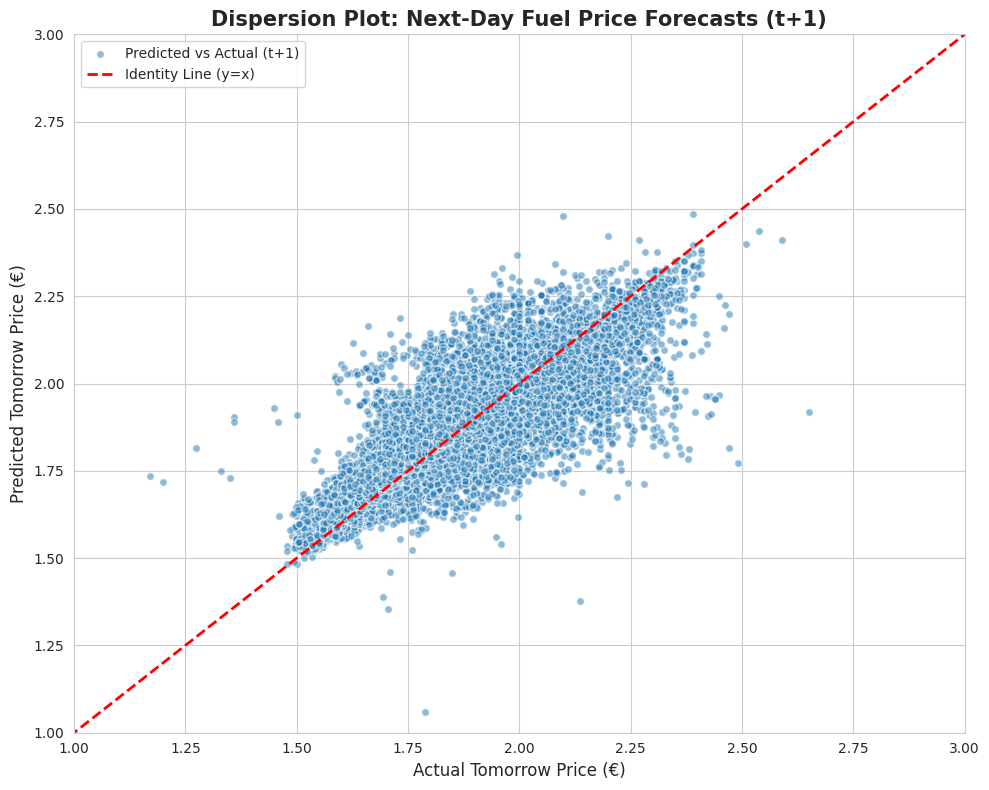

In [108]:
import matplotlib.pyplot as plt

# 1. Data Preparation for Plotting
# We sample to keep the plot lightweight while preserving the distribution
dispersion_pd = predictions.select(
    "target_next_day",
    "prediction"
).sample(False, 0.1, seed=42).toPandas()

# Renaming columns for readability
dispersion_pd = dispersion_pd.rename(columns={
    "target_next_day": "actual_tomorrow_price",
    "prediction": "predicted_tomorrow_price"
})

# 2. Creating the Scatter Plot
plt.figure(figsize=(10, 8))

plt.scatter(
    dispersion_pd["actual_tomorrow_price"],
    dispersion_pd["predicted_tomorrow_price"],
    alpha=0.5,
    edgecolor="w",
    s=30,
    label="Predicted vs Actual (t+1)"
)

# 3. Adding the Identity Line (y = x) in red
min_val = min(dispersion_pd["actual_tomorrow_price"].min(), dispersion_pd["predicted_tomorrow_price"].min())
max_val = max(dispersion_pd["actual_tomorrow_price"].max(), dispersion_pd["predicted_tomorrow_price"].max())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color="red",
    linestyle="--",
    linewidth=2,
    label="Identity Line (y=x)"
)

# 4.Zooming in
plt.xlim(1, 3)
plt.ylim(1, 3)

# 5. Customizing the Visual
plt.title("Dispersion Plot: Next-Day Fuel Price Forecasts (t+1)", fontsize=15, fontweight="bold")
plt.xlabel("Actual Tomorrow Price (€)", fontsize=12)
plt.ylabel("Predicted Tomorrow Price (€)", fontsize=12)
plt.legend(frameon=True)
plt.tight_layout()

plt.show()


The dispersion plot confirms a strong alignment with the identity line, but it also highlights two expected behaviors of a linear, lag-based model:

* **Regression to the Mean (Calibration at Extremes)**: at the tails, the model tends to **slightly overestimate low prices** and **slightly underestimate high prices**. This is a common effect in Linear Regression when relying on a limited set of lag features.
* **Mild Heteroscedasticity**: the spread of points appears to increase for higher price levels, suggesting that prediction uncertainty grows slightly in more extreme regimes.

These effects do not invalidate the pipeline; they simply indicate where additional covariates (fuel type, geography, station attributes) or a more flexible regressor could further improve performance.


In [109]:
from pyspark.sql import functions as F

# Computing absolute error and signed error (bias)
err_df = predictions.select(
    F.col("target_next_day").alias("actual_tomorrow"),
    F.col("prediction").alias("predicted_tomorrow")
).withColumn(
    "abs_error", F.abs(F.col("predicted_tomorrow") - F.col("actual_tomorrow"))
).withColumn(
    "signed_error", F.col("predicted_tomorrow") - F.col("actual_tomorrow")
).cache()

n = err_df.count()

bias = err_df.select(F.avg("signed_error").alias("bias")).first()["bias"]
mae  = err_df.select(F.avg("abs_error").alias("mae")).first()["mae"]

within_5c  = err_df.filter(F.col("abs_error") <= 0.05).count() / n
within_10c = err_df.filter(F.col("abs_error") <= 0.10).count() / n

# Error quantiles (quick distribution summary)
q50, q90, q95 = err_df.approxQuantile("abs_error", [0.50, 0.90, 0.95], 0.001)

print("Operational KPIs (Next-Day Forecast):")
print(f"Mean Bias (pred - actual): {bias:.4f} €")
print(f"MAE: {mae:.4f} €")
print(f"Within ±0.05€: {within_5c*100:.2f}%")
print(f"Within ±0.10€: {within_10c*100:.2f}%")
print(f"Abs Error Quantiles: P50={q50:.4f}€, P90={q90:.4f}€, P95={q95:.4f}€")


Operational KPIs (Next-Day Forecast):
Mean Bias (pred - actual): 0.0001 €
MAE: 0.0332 €
Within ±0.05€: 81.43%
Within ±0.10€: 93.59%
Abs Error Quantiles: P50=0.0181€, P90=0.0771€, P95=0.1132€


The next-day regression model shows strong predictive performance and excellent calibration.

* **Calibration (Bias)**: The mean signed error is **0.0001 €**, effectively zero, indicating no systematic over- or under-estimation.
* **Average Error (MAE)**: The mean absolute error is **0.0332 €** (~3.3 cents), which is low for a next-day forecast based only on lagged prices.
* **Service-Level Accuracy**:
  * **81.43%** of predictions fall within **±0.05 €**
  * **93.59%** of predictions fall within **±0.10 €**
* **Error Distribution (Abs. Error Quantiles)**:
  * **P50 = 0.0181 €** (median error ≈ 1.8 cents)
  * **P90 = 0.0771 €**
  * **P95 = 0.1132 €**

Overall, the model is **operationally reliable**: most forecasts are within a few cents of the true next-day price, and the near-zero bias confirms a well-calibrated pipeline. A small tail of larger errors (P95 > 0.10 €) suggests that extreme price regimes could benefit from additional covariates (e.g., fuel type, geography, station services) or a more flexible regressor.
